# Watershedアルゴリズムを使った画像の領域分割
## 目的
このチュートリアルでは
* watershedアルゴリズムを使ったマーカベースの領域分割の使い方を学ぶ．
* 次の関数の使い方を学ぶ: [cv2.watershed()](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/miscellaneous_transformations.html?highlight=cv2.water#cv2.watershed)

## 理論
あらゆるグレースケールの画像は地形表面とみなすことができる---高い画素値のところは山や丘，低い画素値のところは谷というように．そこで、谷(極小値)のところをみな、異なる色水(ラベル)で満たしてみよう．そして徐々に水かさを増やしてみよう。すると水位の上昇にともなって，近隣の山（勾配）にも依存するが，いろいろな谷からの違う色の水が混ざり始めるだろう．ここで色が混ざらないように、混ざりあいそうな場所に防壁を作ろう．この「水を満たす作業と防壁の作成」とを，全ての峰が水面より下になるまで続けよう．そしてできあがった防壁が領域分割（セグメンテーション)の結果であり、これがwatershedアルゴリズムの “哲学” である．以下のサイトにアニメーションを使った詳しい説明が載っているので見てみよう [ CMM webpage on watershed](http://cmm.ensmp.fr/~beucher/wtshed.html) ．

しかし，この方法を使うとノイズや画像中の不規則性によって過剰に分割した結果が得られることがある．そこでOpenCVでは、全ての極小値に対応する点に対し、統合するべきかどうかを指定する「マーカーに基づくwatershedアルゴリズム」を実装した．これは対話的な領域分割アルゴリズムである。すべき作業は、対象物それぞれに異なるラベルを与えることと、前景だと確信できる領域や単色の（画素値が同じ）物体に対してラベルを与え、背景だと確信できる領域や物体とは思えない領域についてはラベルとして0を与えることである．これが設定したマーカになる．次にwatershedアルゴリズムを適用する．すると設定したマーカはラベルの値で更新され，物体の境界領域には―1の値が与えられるようになる．

## 実装(コード)
以下に、相互に接している物体の領域分割に対し、watershedアルゴリズムと距離変換を使った例を示す．

下の画像ではコインが互いに接している．閾値処理を施したとしても、これらは接したまま分離できない．

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/water_coins.jpg)

コインの概算から始める．そのために大津の二値化を適用する．

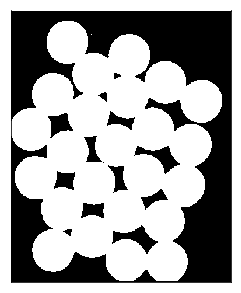

In [9]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('coins.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.figure(figsize=(12,5))
plt.imshow(thresh,'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

さて、二値画像中から小さな白いノイズを取り除かなければならない．そのためにモーフォロジー処理のオープニングを使う．また、物体中の小さな穴を消すにはクロージング処理を使う．これで物体の中心付近の領域は前景であり，物体から離れた領域は背景であることがわかる．唯一わからない領域は，コインとコインの境界領域である．

そこで、コインであると確信できる領域を抽出する必要がある．収縮処理(Erosion)によって境界領域の画素を取り除く．それで残ったものが何であれ，コインであることに確信がもてることになる．この方法は、物体が互いに接していなければうまくいく．しかし今扱っている画像では物体（コイン）が互いに接しているので使えない．そこで別の方法として，距離変換を施し、その結果に対して閾値処理をすることが考えられる．それには，コインではないと確信できる領域を見つける必要がある．それには結果の画像に膨張処理(Dilation)を施す。膨張処理を適用すれば物体の境界が大きくなる．このようにして，境界領域が消去されるため，結果の画像において、背景領域に何があろうとも，それが背景だと確認を持てることになる．下の画像を見てみよう．

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/water_fgbg.jpg)

最終的に、コインなのかそれとも背景なのか、分からない領域が残っている。このような領域は普通コインの境界領域、つまり前景と背景が交わる領域である（もしくは、２つのコインが重なっているかもしれない）。この領域をボーダー(境界）と呼ぶ。ボーダーは前景と確信している領域sure_fgから背景と確信している領域sure_bgを引いた領域として得られる．

In [10]:
# ノイズの除去
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# 確かな背景領域
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# 確かな前景領域を検出
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# 未知の領域を検出
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

結果を見てみよう．閾値処理された画像(右)上では，コインだと確信できる領域が検出できており，更に領域がそれぞれに分離されている(前景領域の抽出のみで十分なケース，つまり相互に接している物体を切り分ける必要が無い時もあるだろう．そのような時は距離変換を使う必要はなく、収縮処理だけで十分である．)．

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/water_dt.jpg)

Text(0.5,1,'Threshold')

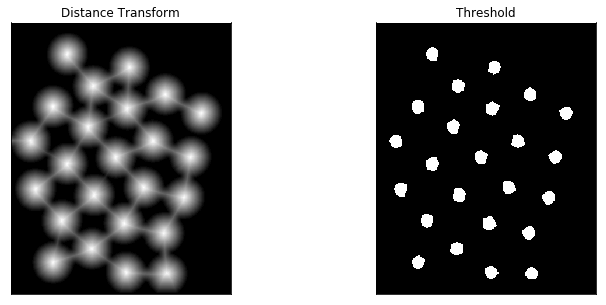

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(dist_transform,'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.title('Distance Transform')
plt.subplot(1,2,2)
plt.imshow(sure_fg,'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.title('Threshold')

さてここで，どの領域がコインで、どの領域が背景であるかは分かっている．そこでマーカを作成し，その中の領域にラベルを与える．ここでマーカとは入力画像と同じサイズで，データタイプが`int32`となる配列である．前景か背景か確信が持てる領域は正の値であればどのような値をラベル付けしても構わない．ただし，それぞれの領域には異なるラベルを与え，どちらの領域か分からない領域に関してはラベル値として0を与える．この作業に `cv2.connectedComponents()` 関数を使う．この関数は画像の背景に0というラベルを与え，それ以外の物体に対して1から順にラベルをつけていくという処理をする．

しかし，背景に対して0ラベルを与えると、watershedアルゴリズムが未知の領域だとみなしてしまう。そこで，背景には別の整数値を与え、` unknown` として定義された未知の領域に対しては0を与えるようにする．

In [26]:
# マーカーにラベル付けする
ret, markers = cv2.connectedComponents(sure_fg)

# すべてのラベルに1を足して、背景を0ではなく1としよう
markers = markers+1

# ここで未知とした領域を0でマークする
markers[unknown==255] = 0

以下のJETカラーマップによって可視化した結果画像を見てみよう．濃い青色は未知の領域を表し、コインと確信している領域は色々な値を持っている．背景と確信されている残りの領域は未知の領域に比べて明るい青色で表されている．

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

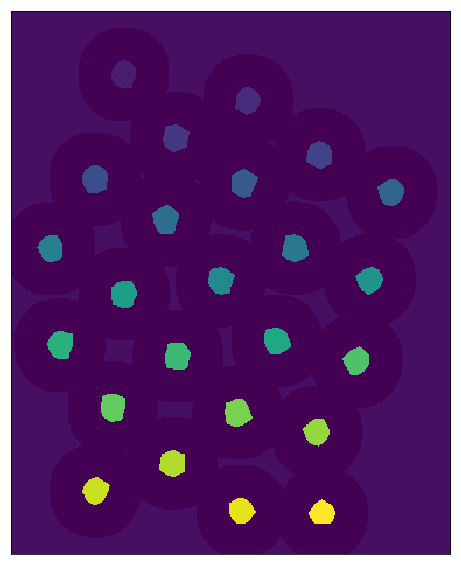

In [27]:
plt.figure(figsize=(15,10))
plt.imshow(markers)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

これでマーカの準備ができた．最後の処理であるwatershedアルゴリズムを適用しよう．するとマーカ画像は変更され、境界領域の値が-1になる．

In [28]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

In [29]:
markers

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       ...,
       [-1,  1,  1, ...,  1,  1, -1],
       [-1,  1,  1, ...,  1,  1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int32)

次に示す結果を見てみよう．接しているコインがうまく分離できている場所と分離できていない場所があるのが分かる．
![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/water_result.jpg)

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

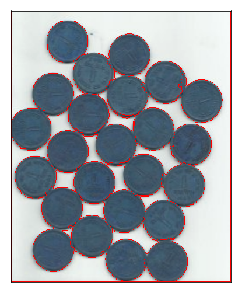

In [30]:
plt.figure(figsize=(15,5))
markers = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

## 補足資料
* CMMの [Watershed Tranformation のページ](http://cmm.ensmp.fr/~beucher/wtshed.html)


## 課題
OpenCVのサンプルに含まれている [watershed.py](https://github.com/opencv/opencv/blob/master/samples/python/watershed.py) を実行して色々と遊んでみよう．

## 目次
* [最初に戻る]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/usingOpenCV.html )
* 一つ上: OpenCVを使った画像処理
OpenCVが提供する様々な画像処理の関数について学ぶ
* 前の学習項目:  [ハフ変換による円検出 houghCircles.ipynb ](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/houghCircles.html)<BR>
画像中の円の検出方法を学ぶ
* 次の学習項目: [GrabCutを使った対話的前景領域抽出 grabCut.ipynb ]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/grabCut.html)<BR>
GrabCutを使った前景領域抽出を学ぶ